In [116]:
# some basic imports
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
from scipy.stats import ttest_ind
import json

# Two additional imports are required; math for the rounding function .ceil(), and scipt.stats for chi2 testing
import math
from scipy.stats import chi2_contingency
from scipy import stats

In [2]:
# data path
DATA = './data/'

# movie metadata loading
df_movies = pd.read_csv(DATA + 'movie.metadata.tsv', sep='\t', header=None)
df_movies.columns = ['wikipedia_id', 'freebase_id', 'title', 'release_date', 'revenue', 
                     'runtime', 'spoken_languages', 'countries', 'genres']

# charcaters metadata loading
df_characters = pd.read_csv(DATA + 'character.metadata.tsv', sep='\t', header=None)
df_characters.columns = ['wikipedia_id', 'freebase_id', 'release', 'character_name', 'actor_birth',
                     'actor_gender', 'actor_height', 'actor_ethnicity', 'actor_name', 
                     'age_at_release', 'freebase_map', 'freebase_character_id', 'freebase_actor_id']

# plot summaries
df_plots = pd.read_csv(DATA + 'plot_summaries.txt', sep='\t', header=None, names=['wikipedia_id', 'plot_summary'])

# TMDB dataset
df_tmdb = pd.read_csv(DATA + 'TMDB_movie_dataset_v11.csv')

In [3]:
# merging movie metadata and TMDB
df_movies_tmdb = pd.merge(df_movies, df_tmdb, on='title', how = 'inner')

In [4]:
# cleaning some movies columns 
def cleaning_fct(pattern):
    if pd.isna(pattern) or pattern == '{}':
        return None
    else:
        dict = json.loads(pattern)
        pattern = list(dict.values())
        return pattern

df_movies_tmdb['spoken_languages_x'] = df_movies_tmdb['spoken_languages_x'].apply(cleaning_fct)
df_movies_tmdb['countries'] = df_movies_tmdb['countries'].apply(cleaning_fct)
df_movies_tmdb['genres_x'] = df_movies_tmdb['genres_x'].apply(cleaning_fct)

df_movies['spoken_languages'] = df_movies['spoken_languages'].apply(cleaning_fct)
df_movies['countries'] = df_movies['countries'].apply(cleaning_fct)
df_movies['genres'] = df_movies['genres'].apply(cleaning_fct)


In [5]:
# from the merged dataset, drop columns with more missing data and renaming the remaining columns
df_movies_tmdb = df_movies_tmdb.drop(['spoken_languages_y'], axis = 1).rename(columns={"spoken_languages_x": "spoken_languages"}) 
df_movies_tmdb = df_movies_tmdb.drop(['genres_y'], axis = 1).rename(columns={"genres_x": "genres"}) 
df_movies_tmdb = df_movies_tmdb.drop(['release_date_x'], axis = 1).rename(columns={"release_date_y": "release_date"}) 

In [6]:
# clean missing values in release_date and clean dates to keep the release year only
df_movies_tmdb = df_movies_tmdb.dropna(subset=['release_date'])
df_movies_tmdb['release_date'] = df_movies_tmdb['release_date'].str[:4].astype(int)

df_movies = df_movies.dropna(subset=['release_date'])
df_movies['release_date'] = df_movies['release_date'].str[:4].astype(int)

In [102]:
df_movies = df_movies[df_movies['release_date'] != '1010']

Basic Statistics

Number of Movies released in a specific year

In [7]:
release_years = df_movies_tmdb['release_date'].unique()
release_years.sort()

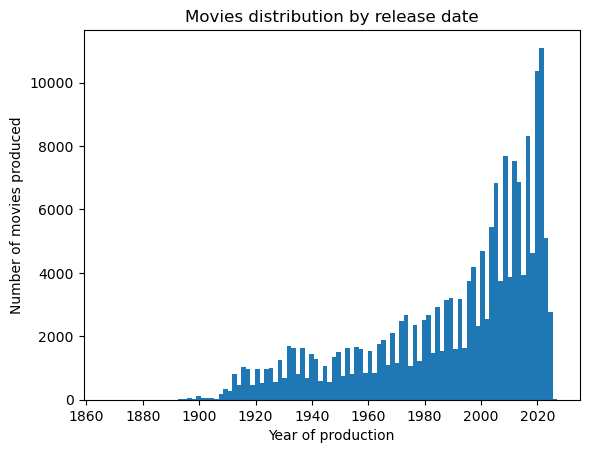

In [8]:
plt.figure()
plt.title('Movies distribution by release date')
plt.hist(df_movies_tmdb['release_date'], bins= 100)
plt.xlabel('Year of production')
plt.ylabel('Number of movies produced')
plt.show()


Number of movies by popularity

0 is the most used value, but it's not meaningful for the analysis because 0 means "no value"

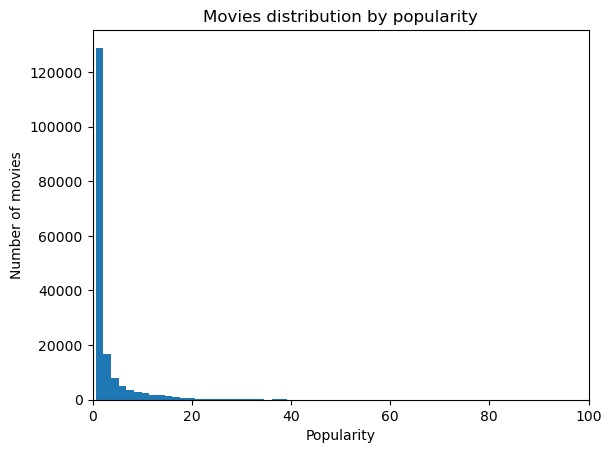

In [9]:
df_movies_tmdb_1 = df_movies_tmdb[df_movies_tmdb['popularity'] != 0]

plt.figure()
plt.title('Movies distribution by popularity')
plt.hist(df_movies_tmdb_1['popularity'], bins= 1000)
plt.xlabel('Popularity')
plt.ylabel('Number of movies')
plt.xlim([0,100])
plt.show()

Grouping by genres

In [10]:
# from now on, if df == df_movies_tmdb, the datset taken into account is df_movies_tmdb
# grouping by genres (need a smaller dataframe to work with)
df_reduced = df_movies_tmdb[['title', 'genres', 'release_date']]

In [11]:
# since there is more than 1 genre for each movie, we have to select all of them
df_grouped_genres = df_reduced.explode('genres')

# groupby genres
df_grouped_genres = df_grouped_genres.groupby('genres')

print("The number of different genres is:")
print(len(df_grouped_genres['genres'].unique()))
print('\n')

# print the groups
print('Print the groups')
for genre, group in df_grouped_genres:
    print(f"Genre: {genre}")
    print(group)

The number of different genres is:
359


Print the groups
Genre: Absurdism
                                             title     genres  release_date
2641                                  Brain Donors  Absurdism          1992
5025                                     Airplane!  Absurdism          1980
5938                           The Golf Specialist  Absurdism          1930
6925                              The Flower Thief  Absurdism          1962
8720               Monty Python and the Holy Grail  Absurdism          1975
...                                            ...        ...           ...
180218          Without a Paddle: Nature's Calling  Absurdism          2009
187443                      Take the Money and Run  Absurdism          1969
189000                   The L.A. Riot Spectacular  Absurdism          2005
191924  Trailer Park Boys: Countdown to Liquor Day  Absurdism          2009
197954                                 Top Secret!  Absurdism          1984

[120 rows x 

In [12]:
title = df_movies.title
df_movies.index = title
df_movies.index.is_unique


False

In [13]:
a = df_movies['title'].unique()
len(a)

69247

Select n most relevant genres, ordering them by recurrence

In [14]:
# counting how many movies share the same genre
counts = df_reduced.explode('genres')['genres'].value_counts()

print('Number of movies for each genre:')
print(counts)
print('\n')

# choosing the most relevant genres
n_relevant_genres = 50
relevant_genres = counts[:n_relevant_genres]

print('The relevant genres are:')
print(relevant_genres)

# making a list of names of the relevant genres
relevant_genres_names = relevant_genres.index.tolist()

Number of movies for each genre:
genres
Drama                 92790
Comedy                31162
Thriller              29519
Romance Film          27931
Black-and-white       21542
                      ...  
Romantic thriller         1
War effort                1
Breakdance                1
Conspiracy fiction        1
Homoeroticism             1
Name: count, Length: 359, dtype: int64


The relevant genres are:
genres
Drama                     92790
Comedy                    31162
Thriller                  29519
Romance Film              27931
Black-and-white           21542
Action                    19490
World cinema              18806
Crime Fiction             18647
Indie                     18528
Short Film                15792
Horror                    15191
Silent film               12907
Action/Adventure          11160
Adventure                 10746
Romantic drama            10043
Mystery                    9910
Musical                    9166
Family Film                8626
Doc

ANALISYS WITH df_movies

In [15]:
# selecting the right columns and cleaning them
df_movies_reduced = df_movies[['title', 'genres', 'release_date']]
df_grouped = df_movies_reduced.explode('genres')
df_grouped = df_grouped.groupby('genres')

print("The number of different genres is:")
print(len(df_grouped['genres'].unique()))
print('\n')

# print the groups
print('Print the groups')
for genre, group in df_grouped:
    print(f"Genre: {genre}")
    print(group)


The number of different genres is:
363


Print the groups
Genre: Absurdism
                                                                                 title  \
title                                                                                    
Brain Donors                                                              Brain Donors   
Airplane!                                                                    Airplane!   
The Golf Specialist                                                The Golf Specialist   
Monty Python and the Holy Grail                        Monty Python and the Holy Grail   
The Magic Christian                                                The Magic Christian   
...                                                                                ...   
Without a Paddle: Nature's Calling                  Without a Paddle: Nature's Calling   
Take the Money and Run                                          Take the Money and Run   
The L.A. Riot Spectacular

In [16]:
# counting how many movies share the same genre
counts = df_movies_reduced.explode('genres')['genres'].value_counts()

print('Number of movies for each genre:')
print(counts)
print('\n')

# choosing the most relevant genres
n_relevant_genres = 20
relevant_genres = counts[:n_relevant_genres]

print('The relevant genres are:')
print(relevant_genres)

# making a list of names of the relevant genres
relevant_genres_names = relevant_genres.index.tolist()

Number of movies for each genre:
genres
Drama                   32015
Comedy                  15648
Romance Film             9770
Black-and-white          8817
Thriller                 8408
                        ...  
Comdedy                     1
C-Movie                     1
Linguistics                 1
Silhouette animation        1
Homoeroticism               1
Name: count, Length: 363, dtype: int64


The relevant genres are:
genres
Drama               32015
Comedy              15648
Romance Film         9770
Black-and-white      8817
Thriller             8408
Action               8275
Short Film           7208
World cinema         7155
Indie                6779
Crime Fiction        6625
Silent film          5056
Documentary          4998
Horror               4982
Adventure            4732
Action/Adventure     4557
Family Film          4165
Musical              3984
Comedy film          3717
Romantic drama       3345
Mystery              3056
Name: count, dtype: int64


Number of movies produced every year, grouped by genres

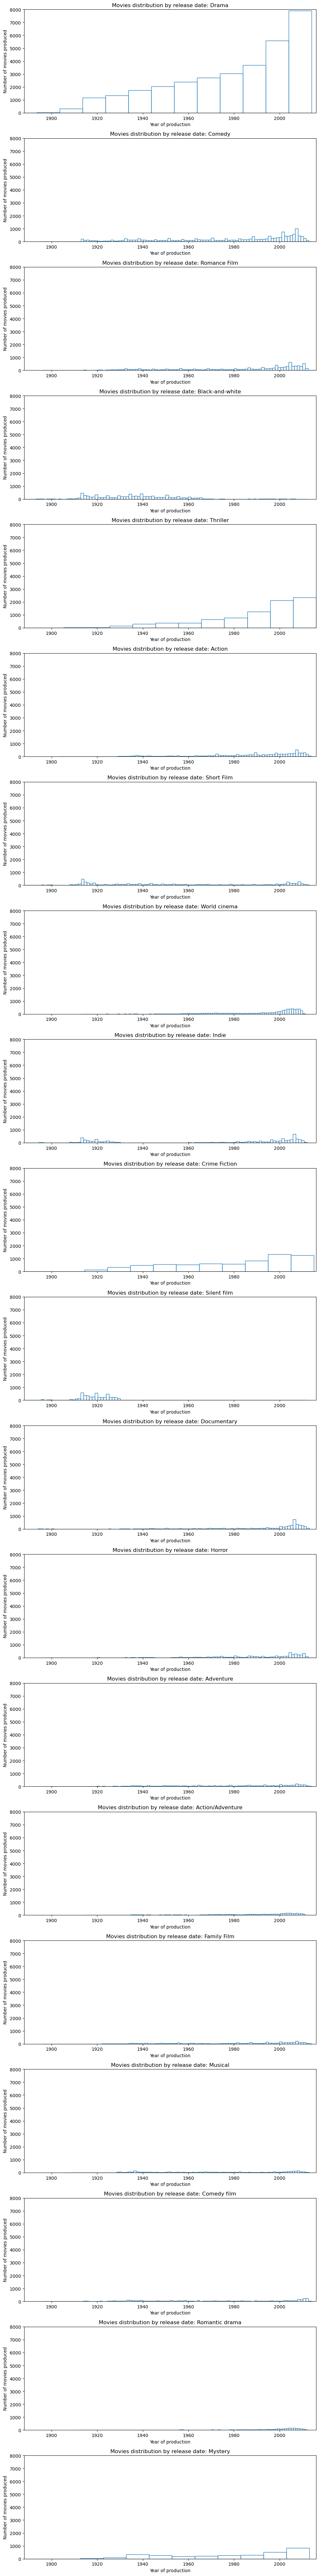

In [17]:
# since the histograms are weird, I choose to drop every row that has missing values but it didn't solve the problem
# df_completeReleaseDate =  df_movies.dropna(subset=['release_date'])

# adjustable plot, depending on the number of relevant genres
n = len(relevant_genres_names) 
fig, axes = plt.subplots(n, 1, figsize = (10, 4 * n))

x_min = 1888
x_max = 2016
y_min = 0
y_max = 8000

for i, genre in enumerate(relevant_genres_names):
    ax = axes[i] 
    ax.set_title(f'Movies distribution by release date: {genre}')
    
    # genres filtering
    genre_movies = df_movies[df_movies['genres'].apply(lambda x: x is not None and genre in x)]
    style = {'facecolor': 'none', 'edgecolor': 'C0', 'linewidth': 1}

    ax.hist(genre_movies['release_date'], bins = 100, **style)
    
    ax.set_xlabel('Year of production')
    ax.set_ylabel('Number of movies produced')

    ax.set_xlim(x_min, x_max)
    ax.set_ylim(y_min, y_max)



plt.tight_layout() 
plt.show()


Same plot as before, but now the yaxis limit is not set: differences inside each graph can be better seen, while comparison between genres may be more difficult

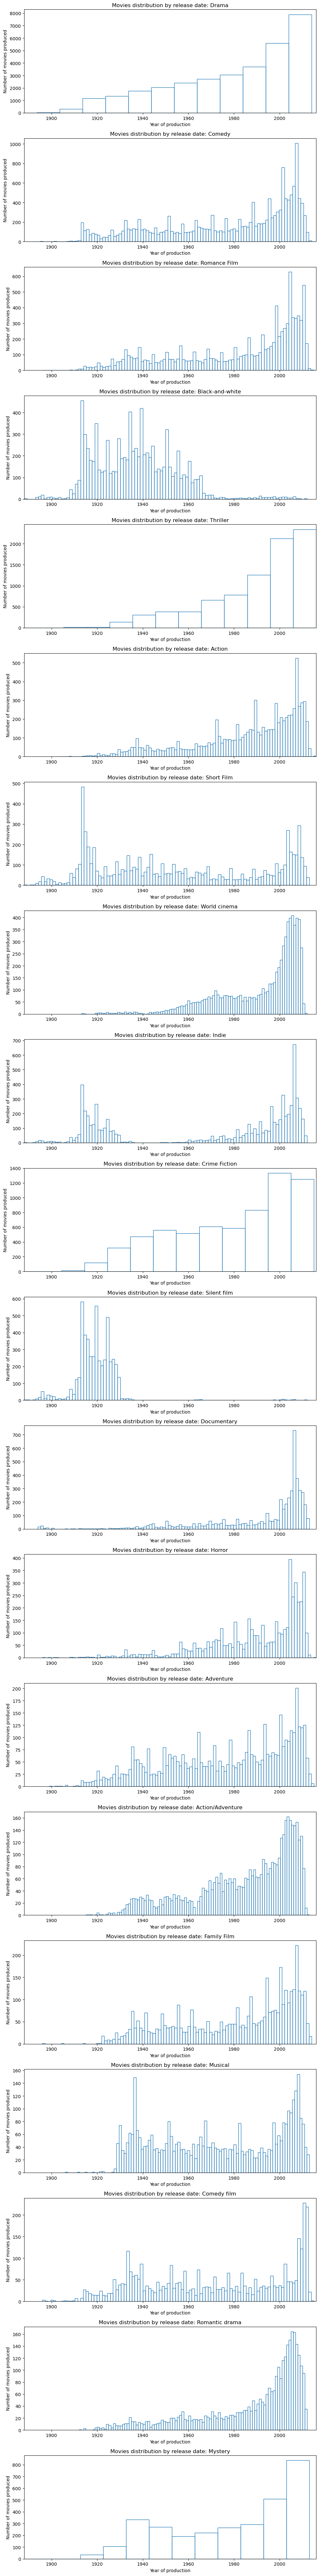

In [18]:
# adjustable plot, depending on the number of relevant genres
n = len(relevant_genres_names) 
fig, axes = plt.subplots(n, 1, figsize = (10, 4 * n))

x_min = 1888
x_max = 2016

for i, genre in enumerate(relevant_genres_names):
    ax = axes[i] 
    ax.set_title(f'Movies distribution by release date: {genre}')
    
    # genres filtering
    genre_movies = df_movies[df_movies['genres'].apply(lambda x: x is not None and genre in x)]
    style = {'facecolor': 'none', 'edgecolor': 'C0', 'linewidth': 1}

    ax.hist(genre_movies['release_date'], bins = 100, **style)
    
    ax.set_xlabel('Year of production')
    ax.set_ylabel('Number of movies produced')

    ax.set_xlim(x_min, x_max)


plt.tight_layout() 
plt.show()

Vote average over date of production of the movie (keep in mind that the voting does not take place in the same year of production, but from then on)

Popularity over date of production of the movie (keep in mind that the popularity does not take place in the same year of production, but from then on) 

From the TMDb documentation: "Popularity is a fairly important metric here on TMDB. It helps us boost search results, adds an incredibly useful sort value for discover, and is also just kind of fun to see items chart up and down. You can think of popularity as being a "lifetime" popularity score that is impacted by the attributes below. It's calculated quite differently than trending."

Number of movies produced in each region (Production Country)

In [19]:
# only a few columns are needed
df_country_reduced = df_movies[['title', 'genres', 'release_date', 'countries']]

In [20]:

# counting how many movies share the same country
country_counts = df_country_reduced.explode('countries')['countries'].value_counts()

print('Number of movies for each country:')
print(country_counts)
print('\n')

# choosing the most relevant genres
n_relevant_countries = 20
relevant_countries = country_counts[:n_relevant_countries]

print('The relevant countries are:')
print(relevant_countries)

# making a list of names of the relevant genres
relevant_countries_names = relevant_countries.index.tolist()

Number of movies for each country:
countries
United States of America    33197
India                        7764
United Kingdom               7452
France                       4199
Italy                        3017
                            ...  
Republic of China               1
Macau                           1
Palestinian Territories         1
German Language                 1
Ukranian SSR                    1
Name: count, Length: 146, dtype: int64


The relevant countries are:
countries
United States of America    33197
India                        7764
United Kingdom               7452
France                       4199
Italy                        3017
Japan                        2405
Canada                       2372
Germany                      2306
Argentina                    1418
Hong Kong                    1115
Spain                        1045
Australia                    1038
South Korea                   861
Mexico                        844
Netherlands               

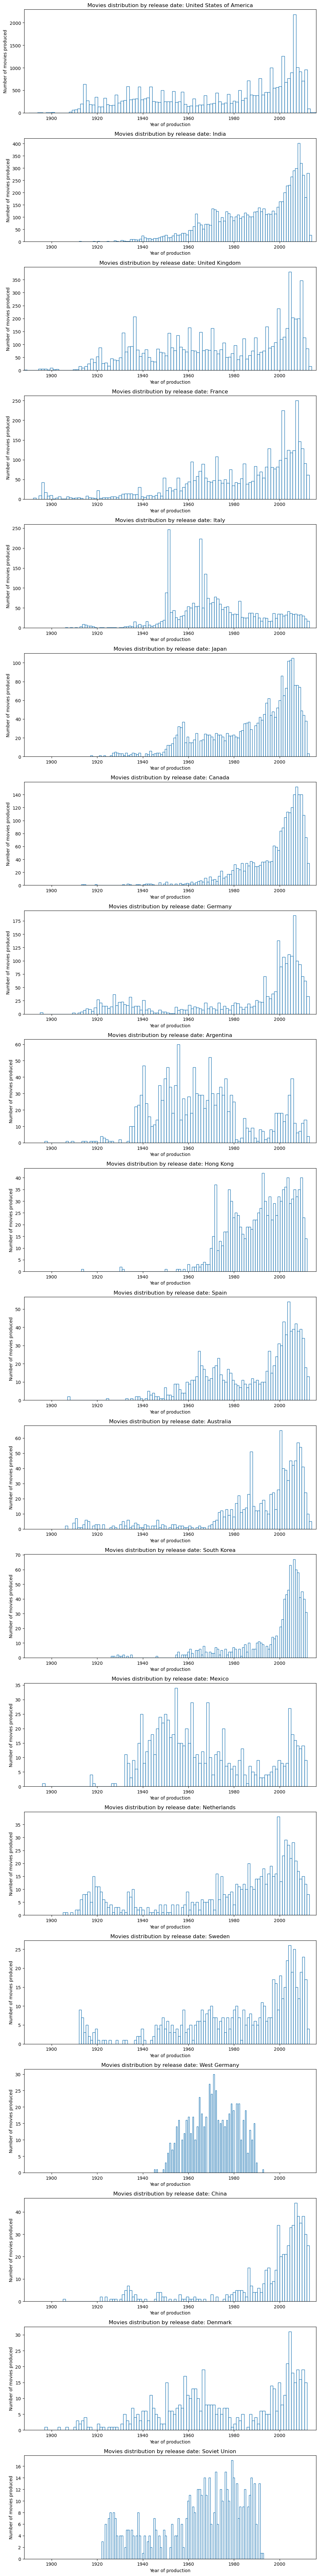

In [21]:
# adjustable plot, depending on the number of relevant genres
n = len(relevant_countries_names) 
fig, axes = plt.subplots(n, 1, figsize = (10, 4 * n))

x_min = 1888
x_max = 2016

for i, country in enumerate(relevant_countries_names):
    ax = axes[i] 
    ax.set_title(f'Movies distribution by release date: {country}')
    
    # country filtering
    country_movies = df_country_reduced[df_country_reduced['countries'].apply(lambda x: x is not None and country in x)]
    style = {'facecolor': 'none', 'edgecolor': 'C0', 'linewidth': 1}

    ax.hist(country_movies['release_date'], bins = 100, **style)
    
    ax.set_xlabel('Year of production')
    ax.set_ylabel('Number of movies produced')

    ax.set_xlim(x_min, x_max)


plt.tight_layout() 
plt.show()

In [22]:
# continents division
northAmerica = ['United States of America ', 'Canada', 'Mexico', 'Cuba', 'Puerto Rico',
                'Panama', 'Jamaica', 'Costa Rica', 'Bahamas', 'Haiti']
europe = ['United Kingdom', 'France', 'Italy', 'Germany','Spain', 'Netherland', 'Sweden', 
          'West Germany', 'Denmark', 'Czechoslovakia' 'Poland', 'Belgium', 'Norway', 'Hungary',
          'German Democratic Republic', 'Yugoslavia', 'Ireland', 'Switzerland', 'Asutria',
          'Czech Republic', 'Finland', 'England', 'Greece', 'Portugal', 'Croatia', 'Romania',
          'Bulgaria', 'Iceland', 'Luxembourg', 'Weimar Republic', 'Serbia', 'Scotland', 'Estonia',
          'Bosnia and Herzegovina', 'Slovakia', 'Slovenia', 'Albania', 'Ukraine', 'Nazi Germany',
          'Republic of Macedonia', 'Lithuania', 'Serbia and Montenegro','Socialist Federal Republic of Yugoslavia',
          'Kingdom of Great Britain', 'Federal Republic of Yugoslavia', 'Slovak Republic', 'Wales',
          'Monaco', 'Cyprus', 'Malta', 'Northern Ireland', 'Montenegro', 'Ukrainian SSR', 'Isle of Man',
          'Kingdom of Italy', 'Crime', 'German Language', 'Ukranian SSR']
asia = ['India', 'Japan', 'Hong Kong', 'South Korea', 'China', 'Soviet Union', 'Philippines',
        'Russia', 'Israel', 'Turkey', 'Thailand', 'Taiwan', 'Iran', 'Pakistan', 'Indonesia',
        'Malaysia', 'Sri Lanka', 'Singapore', 'Bangladesh', 'Lebanon', 'Nepal', 'Vietnam',
        'Korea', 'Azerbaijan', 'Georgia', 'Iraq', 'United Arab Emirates', 'Afghanistan', 'Armenia',
        'Palestinian territories', 'Georgian SSR', 'Mandatory Palestine', 'Uzbek SSR', 'Uzbekistan',
        'Mongolia', 'Kuwait', 'Bahrain', 'Bhutan', 'Qatar', 'Soviet occupation zone', 'Malayalam Language',
        'Jordan', 'Iraqi Kurdistan', 'Republic of China', 'Macau', 'Palestinian Territories']
australia = ['Australia', 'New Zealand']
southAmerica = ['Argentina', 'Brazil', 'Chile', 'Colombia', 'Venezuela', 'Peru', 'Uruguay',
                 'Bolivia', 'Guinea', 'Aruba']
africa = ['South Africa', 'Egypt', 'Cambodia', 'Morocco', 'Senegal', 'Burkina Faso', 'Algeria', 
          'Tunisia', 'Burma', 'Nigeria', 'Republic Democratic of the Congo', 'Mali', 'Kenia',
          'Cameroon', 'Ethiopia', 'Zimbabwe', 'Congo', 'Libya', 'Zambia', 'Guinea-Bissau']

In [23]:
continents = {
    'North America': ['United States of America', 'Canada', 'Mexico', 'Cuba', 'Puerto Rico',
                'Panama', 'Jamaica', 'Costa Rica', 'Bahamas', 'Haiti'],
    'Europe': ['United Kingdom', 'France', 'Italy', 'Germany','Spain', 'Netherland', 'Sweden', 
          'West Germany', 'Denmark', 'Czechoslovakia', 'Poland', 'Belgium', 'Norway', 'Hungary',
          'German Democratic Republic', 'Yugoslavia', 'Ireland', 'Switzerland', 'Asutria',
          'Czech Republic', 'Finland', 'England', 'Greece', 'Portugal', 'Croatia', 'Romania',
          'Bulgaria', 'Iceland', 'Luxembourg', 'Weimar Republic', 'Serbia', 'Scotland', 'Estonia',
          'Bosnia and Herzegovina', 'Slovakia', 'Slovenia', 'Albania', 'Ukraine', 'Nazi Germany',
          'Republic of Macedonia', 'Lithuania', 'Serbia and Montenegro','Socialist Federal Republic of Yugoslavia',
          'Kingdom of Great Britain', 'Federal Republic of Yugoslavia', 'Slovak Republic', 'Wales',
          'Monaco', 'Cyprus', 'Malta', 'Northern Ireland', 'Montenegro', 'Ukrainian SSR', 'Isle of Man',
          'Kingdom of Italy', 'Crime', 'German Language', 'Ukranian SSR'],
    'South America': ['Argentina', 'Brazil', 'Chile', 'Colombia', 'Venezuela', 'Peru', 'Uruguay',
                 'Bolivia', 'Guinea', 'Aruba'],
    'Asia': ['India', 'Japan', 'Hong Kong', 'South Korea', 'China', 'Soviet Union', 'Philippines',
        'Russia', 'Israel', 'Turkey', 'Thailand', 'Taiwan', 'Iran', 'Pakistan', 'Indonesia',
        'Malaysia', 'Sri Lanka', 'Singapore', 'Bangladesh', 'Lebanon', 'Nepal', 'Vietnam',
        'Korea', 'Azerbaijan', 'Georgia', 'Iraq', 'United Arab Emirates', 'Afghanistan', 'Armenia',
        'Palestinian territories', 'Georgian SSR', 'Mandatory Palestine', 'Uzbek SSR', 'Uzbekistan',
        'Mongolia', 'Kuwait', 'Bahrain', 'Bhutan', 'Qatar', 'Soviet occupation zone', 'Malayalam Language',
        'Jordan', 'Iraqi Kurdistan', 'Republic of China', 'Macau', 'Palestinian Territories'],
    'Australia': ['Australia', 'New Zealand'],
    'Africa': ['South Africa', 'Egypt', 'Cambodia', 'Morocco', 'Senegal', 'Burkina Faso', 'Algeria', 
          'Tunisia', 'Burma', 'Nigeria', 'Republic Democratic of the Congo', 'Mali', 'Kenia',
          'Cameroon', 'Ethiopia', 'Zimbabwe', 'Congo', 'Libya', 'Zambia', 'Guinea-Bissau']
}

# dictionary to map each country to a continent
country_to_continent = {country: continent for continent, countries in continents.items() for country in countries}

# drop the rows with no country
df_completeCountry = df_movies.dropna(subset=['countries'])

# extract country names from the lists
df_completeCountry['countries'] = df_completeCountry['countries'].apply(
    lambda x: x[0] if isinstance(x, list) and len(x) > 0 else None
)

# add the column 'continent'
df_completeCountry['continent'] = df_completeCountry['countries'].map(country_to_continent)



C:\Users\chiar\AppData\Local\Temp\ipykernel_43948\3499453944.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_completeCountry['countries'] = df_completeCountry['countries'].apply(
C:\Users\chiar\AppData\Local\Temp\ipykernel_43948\3499453944.py:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_completeCountry['continent'] = df_completeCountry['countries'].map(country_to_continent)


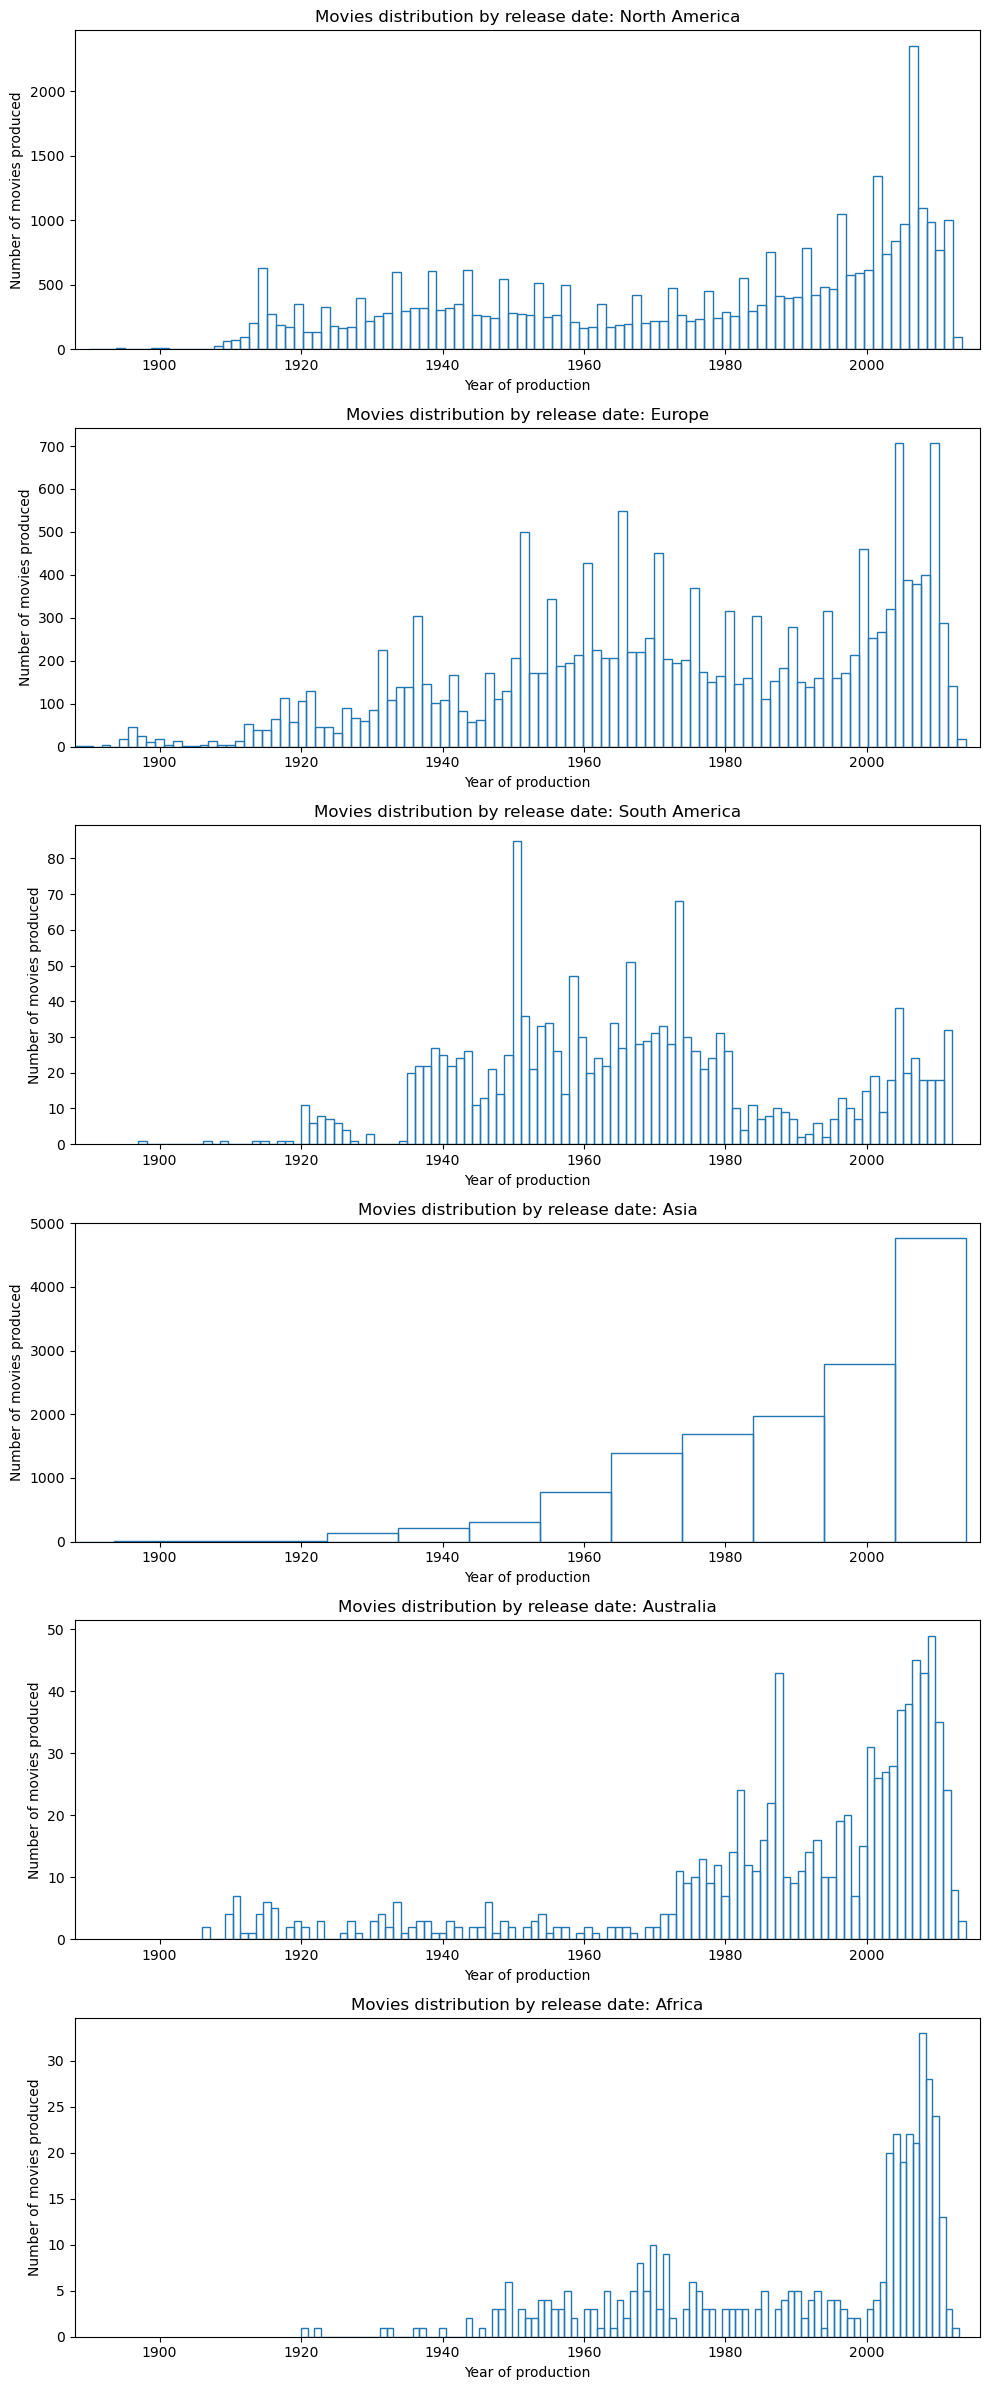

In [24]:
# more cleaning in case no continent is detected
df_completeContinent = df_completeCountry.dropna(subset = ['continent'])


n = 6 
fig, axes = plt.subplots(n, 1, figsize = (10, 4 * n))

x_min = 1888
x_max = 2016

for i, continent in enumerate(['North America', 'Europe', 'South America', 'Asia', 'Australia', 'Africa']):
    ax = axes[i] 
    ax.set_title(f'Movies distribution by release date: {continent}')
    
    # continent filtering
    continent_movies = df_completeContinent[df_completeContinent['continent'].apply(lambda x: isinstance(x, str) and x == continent)]
    style = {'facecolor': 'none', 'edgecolor': 'C0', 'linewidth': 1}

    ax.hist(continent_movies['release_date'], bins = 100, **style)
    
    ax.set_xlabel('Year of production')
    ax.set_ylabel('Number of movies produced')

    ax.set_xlim(x_min, x_max)


plt.tight_layout() 
plt.show()

Pie graphs of each continents, with the number of movies produced in each country, with percentages

In [34]:
# African continent

african_movies = df_completeContinent[df_completeContinent['continent'].apply(lambda x: isinstance(x, str) and x == 'Africa')]
count_african_movies = african_movies.groupby(['countries']).count()
count_african_movies

# since the function "count" counts the number of unique indexes and thw wikipedia_id is a unique index (as well ad the freebase_id and the title), 
# the column wikipedia_id indicates how many different movies were produced in each country

wikipedia_id  freebase_id  title  release_date  revenue  \
countries                                                                
Algeria                  17           17     17            17        0   
Burkina Faso              7            7      7             7        0   
Burma                    22           22     22            22        0   
Cambodia                 56           56     56            56        0   
Cameroon                  5            5      5             5        0   
Egypt                   106          106    106           106        0   
Ethiopia                  4            4      4             4        0   
Guinea-Bissau             1            1      1             1        0   
Libya                     1            1      1             1        0   
Mali                      3            3      3             3        0   
Morocco                  22           22     22            22        0   
Nigeria                  15           15     15            15        0   
Senegal                  13           13     13            13        0   
South Africa            122          122    122           122        6   
Tunisia                  15           15     15            15        0   
Zambia                    1            1      1             1        0   
Zimbabwe                  4            4      4             4        0   

               runtime  spoken_languages  genres  continent  
countries                                                    
Algeria             15                13      16         17  
Burkina Faso         7                 3       7          7  
Burma                5                17      21         22  
Cambodia            23                39      42         56  
Cameroon             4                 4       5          5  
Egypt               67                88      97        106  
Ethiopia             3                 3       4          4  
Guinea-Bissau        1                 1       1          1  
Libya                0                 1       1          1  
Mali                 3                 3       3          3  
Morocco             19                14      20         22  
Nigeria              8                10      15         15  
Senegal             10                11      12         13  
South Africa       107               103     121        122  
Tunisia             14                 8      15         15  
Zambia               1                 1       1          1  
Zimbabwe             3                 3       4          4

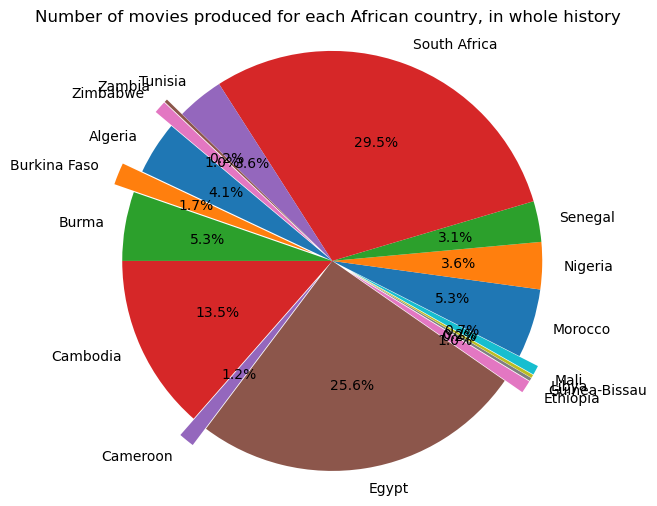

In [52]:
# Africa pie graph


# Explode the small slices of the pie, that cannot be visualized properly
threshold = 2

total_movies = count_african_movies['wikipedia_id'].sum()
small_slices = count_african_movies['wikipedia_id'][(count_african_movies['wikipedia_id'] / total_movies) * 100 < threshold]

explode = [0.1 if count in small_slices.values else 0 for count in count_african_movies['wikipedia_id']]

plt.figure(figsize = (6,6))
plt.title('Number of movies produced for each African country, in whole history')
plt.pie(count_african_movies['wikipedia_id'], labels = count_african_movies.index, autopct = '%1.1f%%',  explode = explode, startangle = 140)
plt.axis('equal')
plt.show()

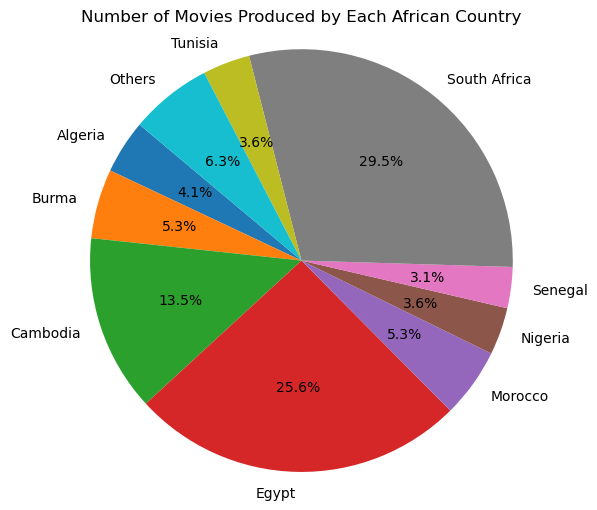

In [87]:
# Better visualization of the same graph
threshold = 2 

total_movies = count_african_movies['wikipedia_id'].sum()

# Identify slices that are too small
small_slices = count_african_movies['wikipedia_id'][(count_african_movies['wikipedia_id'] / total_movies) * 100 < threshold]
large_slices = count_african_movies['wikipedia_id'][(count_african_movies['wikipedia_id'] / total_movies) * 100 >= threshold]

# Combine small slices into an "Others" category
others_count = small_slices.sum()
movie_counts_combined = pd.concat([large_slices, pd.Series(others_count, index=["Others"])])

# Plot the updated pie chart
plt.figure(figsize=(6, 6))
plt.title('Number of Movies Produced by Each African Country')
plt.pie(movie_counts_combined, labels = movie_counts_combined.index, autopct = '%1.1f%%', startangle = 140)
plt.axis('equal')
plt.show()

C:\Users\chiar\AppData\Local\Temp\ipykernel_43948\1863083874.py:18: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  angle = -180 * overall_ratios[0]


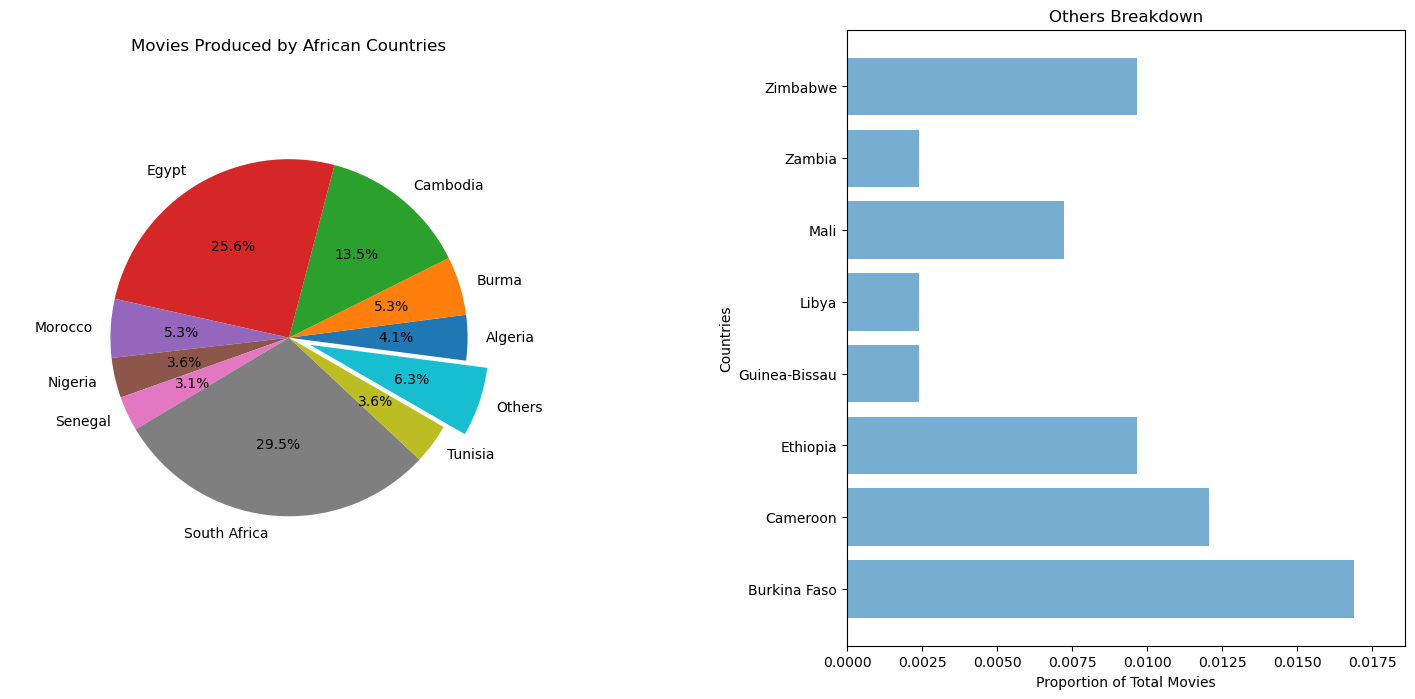

In [89]:
# Other visualization
from matplotlib.patches import ConnectionPatch

# Data for the bar and pie charts
overall_ratios = movie_counts_combined / total_movies
labels = movie_counts_combined.index  
explode = [0.1 if label == "Others" else 0 for label in labels]  # Explode the "Others" slice

# Bar chart for 'others' 
others_breakdown = small_slices / total_movies  # Breakdown of small slices
age_labels = small_slices.index  # Labels for small countries in "Others"

# Create the figure and two subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 8))
fig.subplots_adjust(wspace=0.5)

# Pie chart
angle = -180 * overall_ratios[0]
wedges, texts, autotexts = ax1.pie(overall_ratios, autopct='%1.1f%%', startangle=angle,
                                   labels=labels, explode=explode, radius = 0.8)
ax1.set_title('Movies Produced by African Countries')

# Bar chart for the "Others" breakdown
ax2.barh(others_breakdown.index, others_breakdown, color='C0', alpha=0.6)
ax2.set_title('Others Breakdown')
ax2.set_xlim(0, max(others_breakdown) * 1.1)  # Adjust the x-axis for better spacing
ax2.set_ylabel('Countries')
ax2.set_xlabel('Proportion of Total Movies')

# Use ConnectionPatch to draw lines between the pie and bar chart
theta = (wedges[0].theta1 + wedges[0].theta2) / 2
center, r = wedges[0].center, wedges[0].r
x = r * np.cos(np.pi / 180 * theta) + center[0]
y = r * np.sin(np.pi / 180 * theta) + center[1]

'''
# Draw the connecting lines
con1 = ConnectionPatch(xyA=(0, 0), coordsA=ax2.transData,
                       xyB=(x, y), coordsB=ax1.transData, color='black', linewidth=2)
ax2.add_artist(con1)
'''

# Adjust the second line to go from the bottom of the pie
theta_bottom = (wedges[1].theta1 + wedges[1].theta2) / 2
x_bottom = r * np.cos(np.pi / 180 * theta_bottom) + center[0]
y_bottom = r * np.sin(np.pi / 180 * theta_bottom) + center[1]

'''
con2 = ConnectionPatch(xyA=(0, 0), coordsA=ax2.transData,
                       xyB=(x_bottom, y_bottom), coordsB=ax1.transData, color='black', linewidth=2)
ax2.add_artist(con2)
'''

plt.show()

In [59]:
# Asian continent

asian_movies = df_completeContinent[df_completeContinent['continent'].apply(lambda x: isinstance(x, str) and x == 'Asia')]
count_asian_movies = asian_movies.groupby(['countries']).count()
count_asian_movies

wikipedia_id  freebase_id  title  release_date  \
countries                                                                 
Afghanistan                         7            7      7             7   
Armenia                             8            8      8             8   
Azerbaijan                         14           14     14            14   
Bahrain                             3            3      3             3   
Bangladesh                         62           62     62            62   
Bhutan                              1            1      1             1   
China                             318          318    318           318   
Georgia                            11           11     11            11   
Georgian SSR                        3            3      3             3   
Hong Kong                         996          996    996           996   
India                            7652         7652   7652          7652   
Indonesia                         100          100    100           100   
Iran                              119          119    119           119   
Iraq                                5            5      5             5   
Israel                            121          121    121           121   
Japan                            2089         2089   2089          2089   
Jordan                              1            1      1             1   
Korea                              14           14     14            14   
Kuwait                              2            2      2             2   
Lebanon                            20           20     20            20   
Malayalam Language                  2            2      2             2   
Malaysia                           81           81     81            81   
Mandatory Palestine                 2            2      2             2   
Mongolia                            4            4      4             4   
Nepal                              28           28     28            28   
Pakistan                          135          135    135           135   
Palestinian territories             3            3      3             3   
Philippines                       341          341    341           341   
Qatar                               1            1      1             1   
Russia                            154          154    154           154   
Singapore                          65           65     65            65   
South Korea                       783          783    783           783   
Soviet Union                      469          469    469           469   
Soviet occupation zone              1            1      1             1   
Sri Lanka                          77           77     77            77   
Taiwan                             47           47     47            47   
Thailand                          150          150    150           150   
Turkey                            173          173    173           173   
United Arab Emirates                6            6      6             6   
Uzbek SSR                           3            3      3             3   
Uzbekistan                          6            6      6             6   
Vietnam                            16           16     16            16   

                         revenue  runtime  spoken_languages  genres  continent  
countries                                                                       
Afghanistan                    1        6                 6       6          7  
Armenia                        0        7                 7       8          8  
Azerbaijan                     0        5                 6      13         14  
Bahrain                        0        2                 2       3          3  
Bangladesh                     0       33                59      57         62  
Bhutan                         0        1                 1       1          1  
China                         11      278               288     318        3

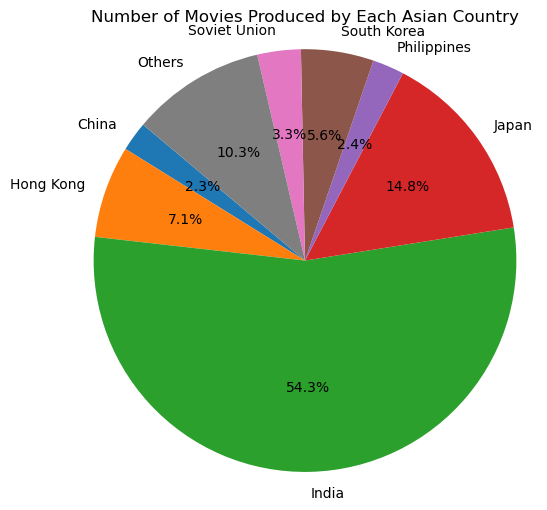

In [85]:
threshold = 2 

total_movies = count_asian_movies['wikipedia_id'].sum()

# Identify slices that are too small
small_slices = count_asian_movies['wikipedia_id'][(count_asian_movies['wikipedia_id'] / total_movies) * 100 < threshold]
large_slices = count_asian_movies['wikipedia_id'][(count_asian_movies['wikipedia_id'] / total_movies) * 100 >= threshold]

# Combine small slices into an "Others" category
others_count = small_slices.sum()
movie_counts_combined = pd.concat([large_slices, pd.Series(others_count, index=["Others"])])

# Plot the pie chart
plt.figure(figsize=(6, 6))
plt.title('Number of Movies Produced by Each Asian Country')
plt.pie(movie_counts_combined, labels = movie_counts_combined.index, autopct = '%1.1f%%', startangle = 140)
plt.axis('equal')
plt.show()

C:\Users\chiar\AppData\Local\Temp\ipykernel_43948\3130839802.py:18: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  angle = -180 * overall_ratios[0]


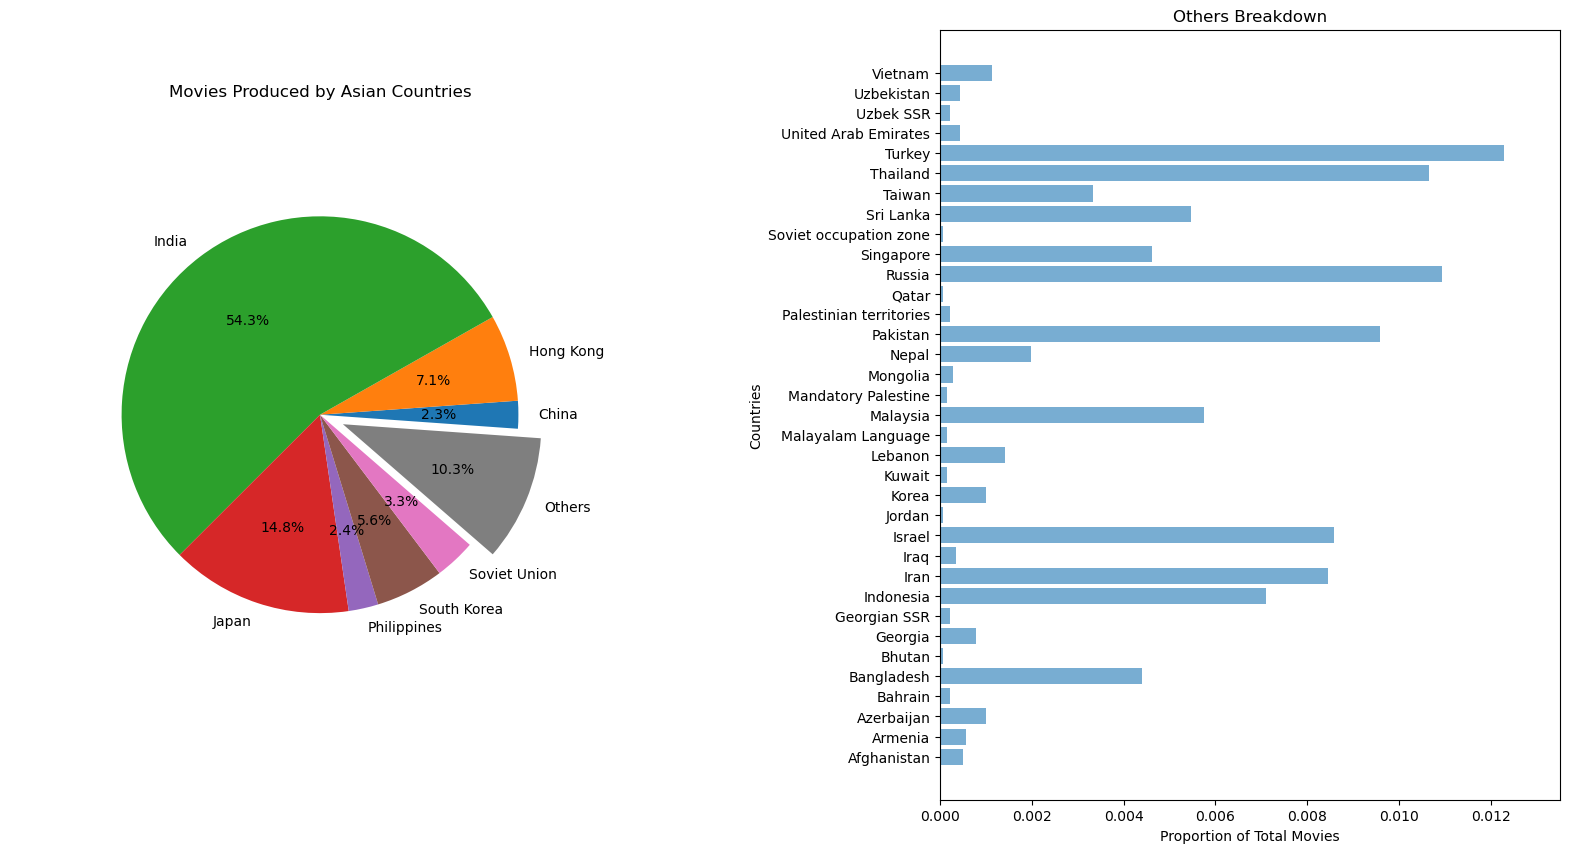

In [86]:
# Other visualization
from matplotlib.patches import ConnectionPatch

# Data for the bar and pie charts
overall_ratios = movie_counts_combined / total_movies
labels = movie_counts_combined.index  
explode = [0.1 if label == "Others" else 0 for label in labels]  # Explode the "Others" slice

# Bar chart for 'others' 
others_breakdown = small_slices / total_movies  # Breakdown of small slices
age_labels = small_slices.index  # Labels for small countries in "Others"

# Create the figure and two subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))
fig.subplots_adjust(wspace=0.5)

# Pie chart
angle = -180 * overall_ratios[0]
wedges, texts, autotexts = ax1.pie(overall_ratios, autopct='%1.1f%%', startangle=angle,
                                   labels=labels, explode=explode, radius = 0.8)
ax1.set_title('Movies Produced by Asian Countries')

# Bar chart for the "Others" breakdown
ax2.barh(others_breakdown.index, others_breakdown, color='C0', alpha=0.6)
ax2.set_title('Others Breakdown')
ax2.set_xlim(0, max(others_breakdown) * 1.1)  # Adjust the x-axis for better spacing
ax2.set_ylabel('Countries')
ax2.set_xlabel('Proportion of Total Movies')

# Use ConnectionPatch to draw lines between the pie and bar chart
theta = (wedges[0].theta1 + wedges[0].theta2) / 2
center, r = wedges[0].center, wedges[0].r
x = r * np.cos(np.pi / 180 * theta) + center[0]
y = r * np.sin(np.pi / 180 * theta) + center[1]

'''
# Draw the connecting lines
con1 = ConnectionPatch(xyA=(0, 0), coordsA=ax2.transData,
                       xyB=(x, y), coordsB=ax1.transData, color='black', linewidth=2)
ax2.add_artist(con1)
'''

# Adjust the second line to go from the bottom of the pie
theta_bottom = (wedges[1].theta1 + wedges[1].theta2) / 2
x_bottom = r * np.cos(np.pi / 180 * theta_bottom) + center[0]
y_bottom = r * np.sin(np.pi / 180 * theta_bottom) + center[1]

'''
con2 = ConnectionPatch(xyA=(0, 0), coordsA=ax2.transData,
                       xyB=(x_bottom, y_bottom), coordsB=ax1.transData, color='black', linewidth=2)
ax2.add_artist(con2)
'''

plt.show()

In [63]:
# Europe

european_movies = df_completeContinent[df_completeContinent['continent'].apply(lambda x: isinstance(x, str) and x == 'Europe')]
count_european_movies = european_movies.groupby(['countries']).count()
count_european_movies


wikipedia_id  freebase_id  title  \
countries                                                                    
Albania                                             19           19     19   
Belgium                                            128          128    128   
Bosnia and Herzegovina                               8            8      8   
Bulgaria                                            66           66     66   
Crime                                                1            1      1   
Croatia                                            108          108    108   
Cyprus                                               3            3      3   
Czech Republic                                     141          141    141   
Czechoslovakia                                     318          318    318   
Denmark                                            496          496    496   
England                                            138          138    138   
Estonia                                             24           24     24   
Federal Republic of Yugoslavia                       6            6      6   
Finland                                            206          206    206   
France                                            3804         3804   3804   
German Democratic Republic                         301          301    301   
Germany                                            747          747    747   
Greece                                             115          115    115   
Hungary                                            231          231    231   
Iceland                                             58           58     58   
Ireland                                            164          164    164   
Isle of Man                                          2            2      2   
Italy                                             1811         1811   1811   
Kingdom of Great Britain                            11           11     11   
Lithuania                                            8            8      8   
Luxembourg                                           7            7      7   
Malta                                                2            2      2   
Nazi Germany                                        18           18     18   
Northern Ireland                                     5            5      5   
Norway                                             216          216    216   
Poland                                             327          327    327   
Portugal                                            67           67     67   
Republic of Macedonia                                9            9      9   
Romania                                             71           71     71   
Scotland                                             5            5      5   
Serbia                                              27           27     27   
Serbia and Montenegro                               14           14     14   
Slovak Republic                                      2            2      2   
Slovakia                                            21           21     21   
Slovenia                                            18           18     18   
Socialist Federal Republic of Yugoslavia             5            5      5   
Spain                                              676          676    676   
Sweden                                             429          429    429   
Switzerland                                        162          162    162   
Ukraine                                             21           21     21   
Ukrainian SSR                                        4            4      4   
Ukranian SSR                                         1            1      1   
United Kingdom                                    5114         5114   5114   
Wales                                                5            5      5   
Weimar Republic                                     66          

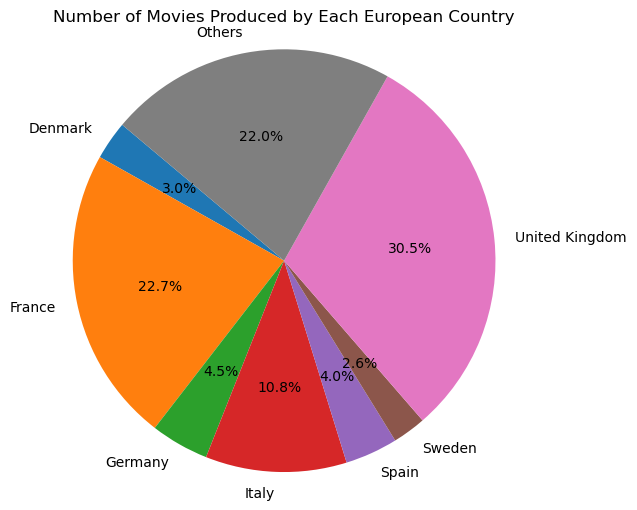

In [67]:
threshold = 2 

total_movies = count_european_movies['wikipedia_id'].sum()

# Identify slices that are too small
small_slices = count_european_movies['wikipedia_id'][(count_european_movies['wikipedia_id'] / total_movies) * 100 < threshold]
large_slices = count_european_movies['wikipedia_id'][(count_european_movies['wikipedia_id'] / total_movies) * 100 >= threshold]

# Combine small slices into an "Others" category
others_count = small_slices.sum()
movie_counts_combined = pd.concat([large_slices, pd.Series(others_count, index=["Others"])])

# Plot the updated pie chart
plt.figure(figsize=(6, 6))
plt.title('Number of Movies Produced by Each European Country')
plt.pie(movie_counts_combined, labels = movie_counts_combined.index, autopct = '%1.1f%%', startangle = 140)
plt.axis('equal')
plt.show()

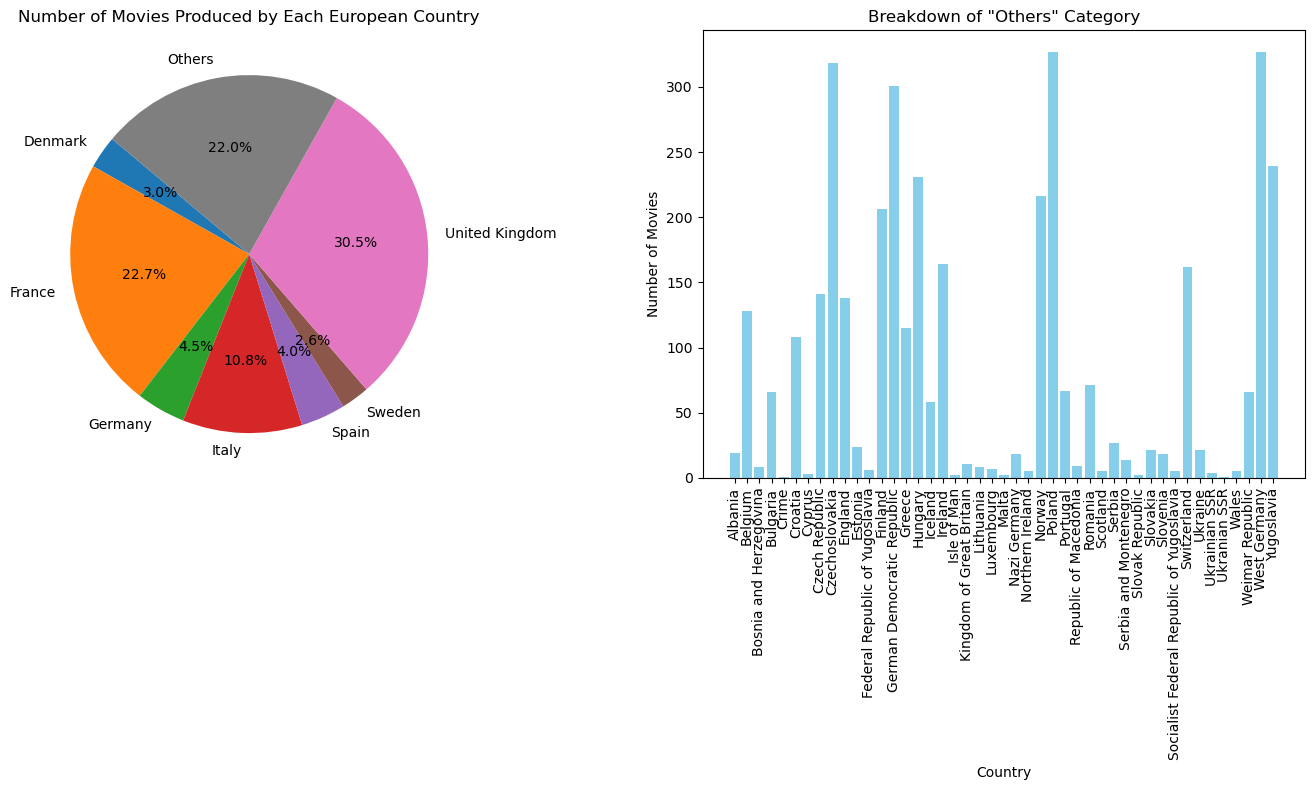

In [70]:
# Insertion of the bar of a pie

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 8))

ax1.pie(movie_counts_combined, labels=movie_counts_combined.index, autopct='%1.1f%%', startangle=140)
ax1.set_title('Number of Movies Produced by Each European Country')

# Bar Chart for the 'Others'
ax2.bar(small_slices.index, small_slices.values, color='skyblue')
ax2.set_title('Breakdown of "Others" Category')
ax2.set_xlabel('Country')
ax2.set_ylabel('Number of Movies')
ax2.tick_params(axis='x', rotation=90) 
plt.tight_layout()
plt.show()

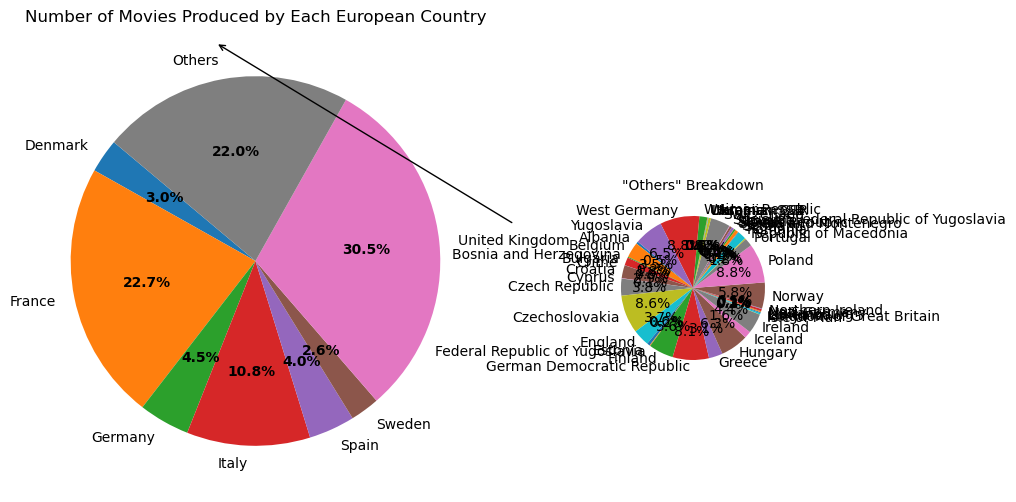

In [73]:
# Other visualization

fig, ax1 = plt.subplots(figsize=(10, 6))

# Plot the main pie chart
wedges, texts, autotexts = ax1.pie(
    movie_counts_combined,
    labels=movie_counts_combined.index,
    autopct='%1.1f%%',
    startangle=140
)

plt.setp(autotexts, size=10, weight="bold")
ax1.set_title('Number of Movies Produced by Each European Country')

# Add an inset axis for the "Others" breakdown
ax2 = plt.axes([0.8, 0.3, 0.3, 0.3])  # Adjust position [left, bottom, width, height]
ax2.pie(
    small_slices,
    labels=small_slices.index,
    autopct='%1.1f%%',
    startangle=140
)
ax2.set_title('"Others" Breakdown', fontsize=10)

# Line connecting the pie charts
for i, wedge in enumerate(wedges):
    if movie_counts_combined.index[i] == "Others":
        # Get the angle for the "Others" slice
        theta = (wedge.theta1 + wedge.theta2) / 2
        x = 1.2 * wedge.r * np.cos(theta * np.pi / 180)  # Adjust position if necessary
        y = 1.2 * wedge.r * np.sin(theta * np.pi / 180)
        # Draw a line from the "Others" slice to the smaller pie chart
        ax1.annotate('', xy=(x, y), xytext=(1.4, 0.2), arrowprops=dict(arrowstyle="->"))

plt.show()

C:\Users\chiar\AppData\Local\Temp\ipykernel_43948\2323721431.py:18: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  angle = -180 * overall_ratios[0]


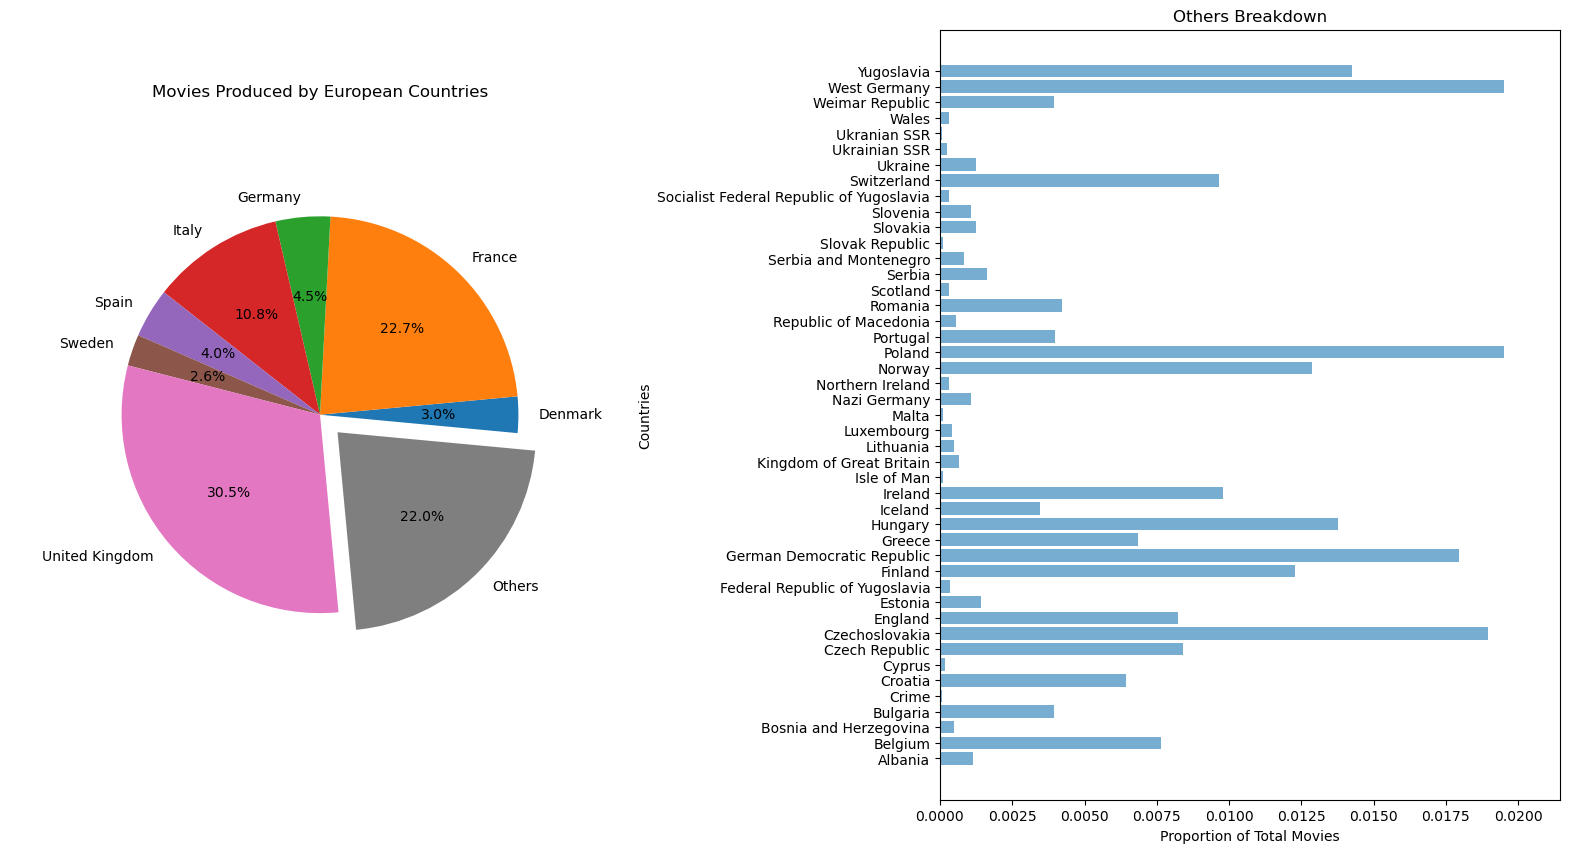

In [84]:
# Other visualization
from matplotlib.patches import ConnectionPatch

# Data for the bar and pie charts
overall_ratios = movie_counts_combined / total_movies
labels = movie_counts_combined.index  
explode = [0.1 if label == "Others" else 0 for label in labels]  # Explode the "Others" slice

# Bar chart for 'others' 
others_breakdown = small_slices / total_movies  # Breakdown of small slices
age_labels = small_slices.index  # Labels for small countries in "Others"

# Create the figure and two subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))
fig.subplots_adjust(wspace=0.5)

# Pie chart
angle = -180 * overall_ratios[0]
wedges, texts, autotexts = ax1.pie(overall_ratios, autopct='%1.1f%%', startangle=angle,
                                   labels=labels, explode=explode, radius = 0.8)
ax1.set_title('Movies Produced by European Countries')

# Bar chart for the "Others" breakdown
ax2.barh(others_breakdown.index, others_breakdown, color='C0', alpha=0.6)
ax2.set_title('Others Breakdown')
ax2.set_xlim(0, max(others_breakdown) * 1.1)  # Adjust the x-axis for better spacing
ax2.set_ylabel('Countries')
ax2.set_xlabel('Proportion of Total Movies')

# Use ConnectionPatch to draw lines between the pie and bar chart
theta = (wedges[0].theta1 + wedges[0].theta2) / 2
center, r = wedges[0].center, wedges[0].r
x = r * np.cos(np.pi / 180 * theta) + center[0]
y = r * np.sin(np.pi / 180 * theta) + center[1]

'''
# Draw the connecting lines
con1 = ConnectionPatch(xyA=(0, 0), coordsA=ax2.transData,
                       xyB=(x, y), coordsB=ax1.transData, color='black', linewidth=2)
ax2.add_artist(con1)
'''

# Adjust the second line to go from the bottom of the pie
theta_bottom = (wedges[1].theta1 + wedges[1].theta2) / 2
x_bottom = r * np.cos(np.pi / 180 * theta_bottom) + center[0]
y_bottom = r * np.sin(np.pi / 180 * theta_bottom) + center[1]

'''
con2 = ConnectionPatch(xyA=(0, 0), coordsA=ax2.transData,
                       xyB=(x_bottom, y_bottom), coordsB=ax1.transData, color='black', linewidth=2)
ax2.add_artist(con2)
'''

plt.show()

Plot number of movies per relevant countries during time, in the same figure

In [97]:
continents_grouped = df_completeContinent.groupby(['countries']).count()

In [99]:
df_completeContinent.columns

Index(['wikipedia_id', 'freebase_id', 'title', 'release_date', 'revenue',
       'runtime', 'spoken_languages', 'countries', 'genres', 'continent'],
      dtype='object')

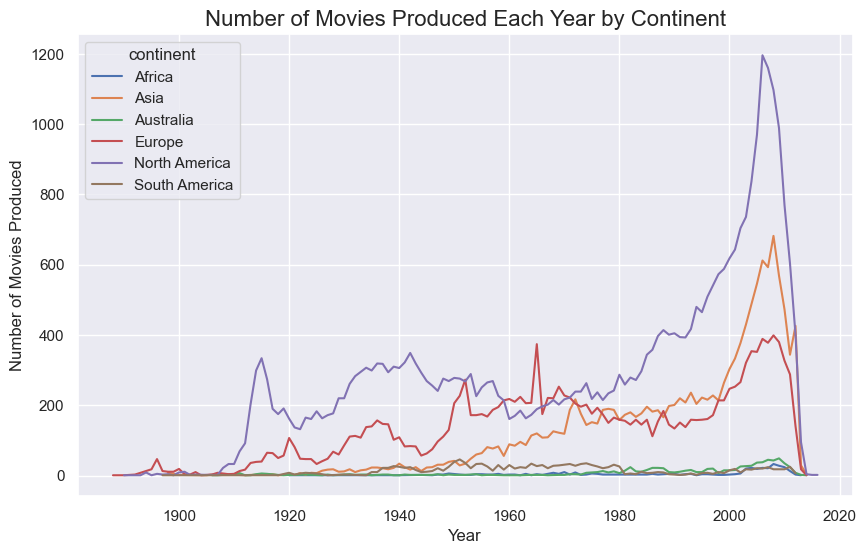

In [106]:
import seaborn as sns
df_completeContinent = df_completeContinent[df_completeContinent['release_date'] != 1010]

# Group by continent and year to count the number of movies produced
continents_grouped = df_completeContinent.groupby(['continent', 'release_date']).size().reset_index(name='movie_count')

# Set the Seaborn theme
sns.set_theme(style="darkgrid")
plt.figure(figsize=(10, 6))
sns.lineplot(x="release_date", y="movie_count", hue="continent", data=continents_grouped)
plt.title("Number of Movies Produced Each Year by Continent", fontsize=16)
plt.xlabel("Year", fontsize=12)
plt.ylabel("Number of Movies Produced", fontsize=12)
plt.show()

In [ ]:
continents_grouped[continents_grouped['continent'] == 'Asia']['movie_count'].mean()

print(stats.ttest_ind(continents_grouped[continents_grouped['continent'] == 'North America']['movie_count'], 
                continents_grouped[continents_grouped['continent'] == 'Asia']['movie_count']))

# p-value << 0.05 --> there is  significant difference between the means  
# (reject the null hypothesis that the movie_count is the same)

print(stats.ttest_ind(continents_grouped[continents_grouped['continent'] == 'North America']['movie_count'], 
                continents_grouped[continents_grouped['continent'] == 'Europe']['movie_count']))

# p-value << 0.05 --> there is significant difference between the means

print(stats.ttest_ind(continents_grouped[continents_grouped['continent'] == 'Europe']['movie_count'], 
                continents_grouped[continents_grouped['continent'] == 'Asia']['movie_count']))

# p-value > 0.05 --> there is not significant difference between the means

print(stats.ttest_ind(continents_grouped[continents_grouped['continent'] == 'Australia']['movie_count'], 
                continents_grouped[continents_grouped['continent'] == 'South America']['movie_count']))

# p-value << 0.05 --> there is significant difference between the means

print(stats.ttest_ind(continents_grouped[continents_grouped['continent'] == 'South America']['movie_count'], 
                continents_grouped[continents_grouped['continent'] == 'Africa']['movie_count']))

# p-value << 0.05 --> there is significant difference between the means

print(stats.ttest_ind(continents_grouped[continents_grouped['continent'] == 'Australia']['movie_count'], 
                continents_grouped[continents_grouped['continent'] == 'Africa']['movie_count']))

# p-value < 0.05 --> there is significant difference between the means

TtestResult(statistic=5.254119523442683, pvalue=3.4344179902995614e-07, df=226.0)
TtestResult(statistic=6.235444652300928, pvalue=1.937118332031565e-09, df=247.0)
TtestResult(statistic=-0.09117524242762616, pvalue=0.9274344653196205, df=225.0)
TtestResult(statistic=-4.537305051977054, pvalue=1.0084190424514223e-05, df=190.0)
TtestResult(statistic=7.117488777364447, pvalue=3.149610932396782e-11, df=166.0)
TtestResult(statistic=2.312438037930107, pvalue=0.02196659799986305, df=168.0)


War Films Genre

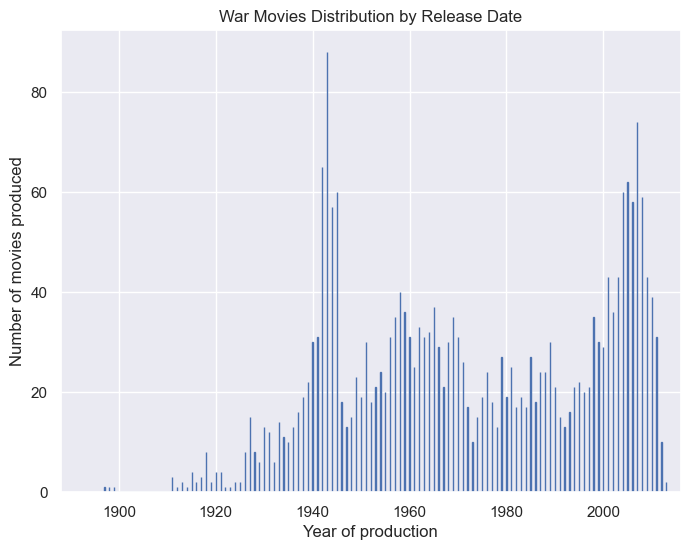

In [144]:
# adjustable plot, depending on the number of relevant genres
plt.figure(figsize=(8,6))
plt.title('War Movies Distribution by Release Date')

war_movies = df_completeContinent[df_completeContinent['genres'].apply(lambda x: x is not None and 'War film' in x)]
plt.hist(war_movies['release_date'], bins = len(war_movies['release_date']), **style)

plt.xlabel('Year of production')
plt.ylabel('Number of movies produced')
plt.xlim(x_min, x_max)
plt.show()

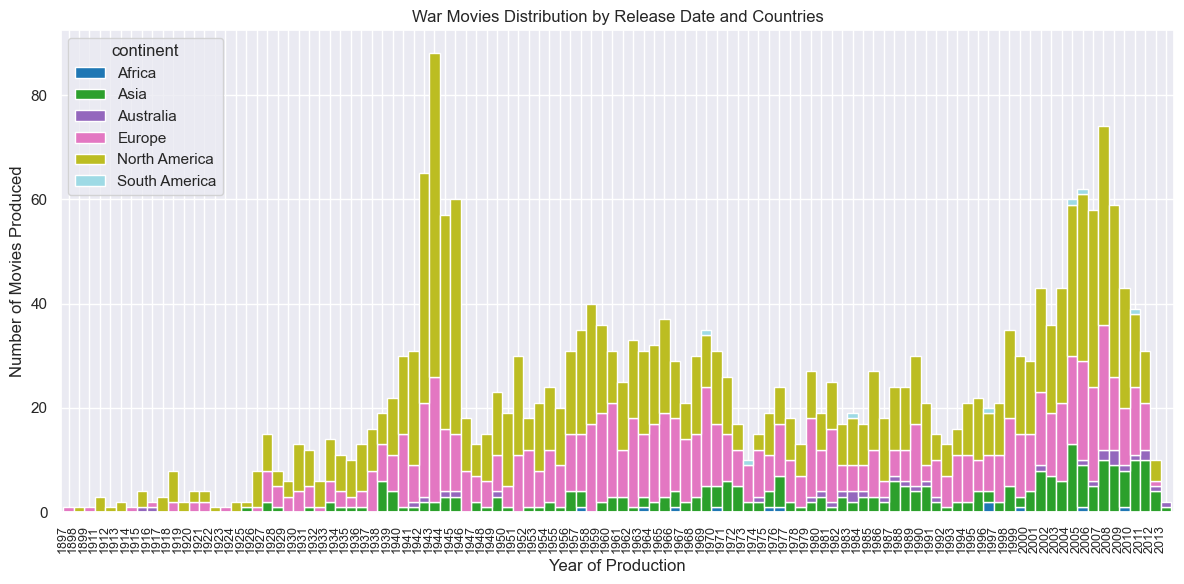

In [174]:
# 'countries' column is exploded because it contains lists
#war_movies_expanded = war_movies.explode('countries')

# Group by release_date and countries, and count the occurrences
#grouped_war_movies = war_movies_expanded.groupby(['release_date', 'countries']).size().unstack(fill_value=0)

grouped_war_movies = war_movies.groupby(['release_date', 'continent']).size().unstack(fill_value=0)

# Plot stacked bar chart for grouped war movies
ax = grouped_war_movies.plot(kind='bar', stacked=True, figsize=(12, 6), colormap='tab20', width=1)
plt.title('War Movies Distribution by Release Date and Countries')

# Adjust the x-ticks and labels
plt.xlabel('Year of Production')
plt.ylabel('Number of Movies Produced')

#x_ticks = range(grouped_war_movies.index.min(), grouped_war_movies.index.max() + 1, 5)
#ax.set_xticks(x_ticks) 
plt.xticks(rotation=90, ha="right", fontsize=9)  # Rotate x labels for better readability


plt.tight_layout()

# Show the plot
plt.show()

                Genre  Frequency
3               Drama       1567
18             Action        520
12   Action/Adventure        334
15       Romance Film        333
7     Black-and-white        330
..                ...        ...
173     Monster movie          1
100               Gay          1
176         Steampunk          1
177   Christmas movie          1
204     Homoeroticism          1

[205 rows x 2 columns]


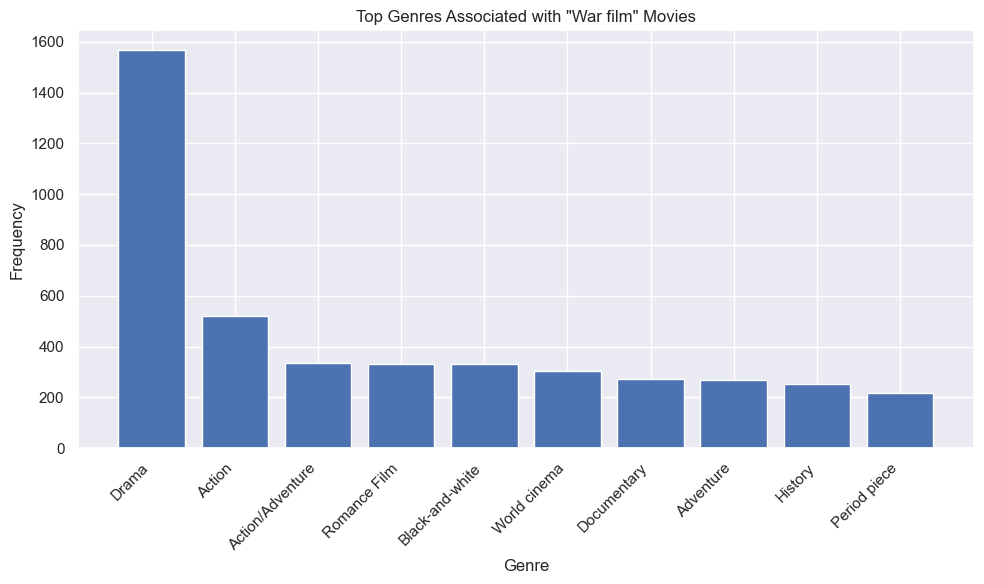

In [175]:
from collections import Counter

# here we collect the combined genres
war_combined_genres = []

for genres in war_movies['genres']:
    if isinstance(genres, list):  # Check if genres is a list
        war_combined_genres.extend([genre for genre in genres if genre != 'War film'])

war_combined_genres_counts = Counter(war_combined_genres)
war_combined_genres_df = pd.DataFrame(war_combined_genres_counts.items(), columns=['Genre', 'Frequency'])

war_combined_genres_df = war_combined_genres_df.sort_values(by='Frequency', ascending=False)

# Display the result
print(war_combined_genres_df)

# Optional: Plotting the top genres
plt.figure(figsize=(10, 6))
plt.bar(war_combined_genres_df['Genre'][:10], war_combined_genres_df['Frequency'][:10])  # Top 10 genres
plt.xticks(rotation=45, ha='right')
plt.title('Top Genres Associated with "War film" Movies')
plt.xlabel('Genre')
plt.ylabel('Frequency')
plt.tight_layout()
plt.show()